In [6]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [7]:
target_df = (pd.read_excel('RESPONSE Main 1m.xls', skiprows=range(6)).rename(columns=lambda x: x.strip())
             .assign(**{'Effective date': lambda df: pd.to_datetime(df['Effective date'], errors='coerce')})
             .dropna(subset=['Effective date']).set_index('Effective date'))

data = target_df.iloc[:, 0].dropna().iloc[:-150]

def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# (Pagan and Schwer, 1990) 
def calculate_log_loss(actual, forecast):
    return np.mean((np.log(actual / forecast))**2)

num_lags = 3 # set # of lags

def create_features(data, lag):
    return np.column_stack([data.shift(i) for i in range(lag, 0, -1)])

lagged_data = create_features(data, lag=num_lags)
X = lagged_data[num_lags:]
y = data.values[num_lags:]

# walk-forward validation w/ 5 splits
splits = TimeSeriesSplit(n_splits=5)

forecasts = []
forecast_indices = []
mae_scores = []
mape_scores = []
log_loss_scores = []

for train_idx, test_idx in splits.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # standardise features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # SVR w/ linear kernel (Abdullah Karasan, 2022)
    svr = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=0.01)
    svr.fit(X_train_scaled, y_train)

    # n-step prediction
    forecast = svr.predict(X_test_scaled)
    forecasts.append(forecast[0])
    forecast_indices.append(test_idx[0])
    mae_scores.append(mean_absolute_error([y_test[0]], [forecast[0]]))
    mape_scores.append(calculate_mape(np.array([y_test[0]]), np.array([forecast[0]])))
    log_loss_scores.append(calculate_log_loss(np.array([y_test[0]]), np.array([forecast[0]])))

# loss fxs
average_mae = np.mean(mae_scores)
average_mape = np.mean(mape_scores)
average_log_loss = np.mean(log_loss_scores)

print(f"Avg MAE: {average_mae:.3f}")
print(f"Avg MAPE: {average_mape:.3f}")
print(f"Avg Log Loss: {average_log_loss:.5f}")

Avg MAE: 1.008
Avg MAPE: 2.229
Avg Log Loss: 0.00060


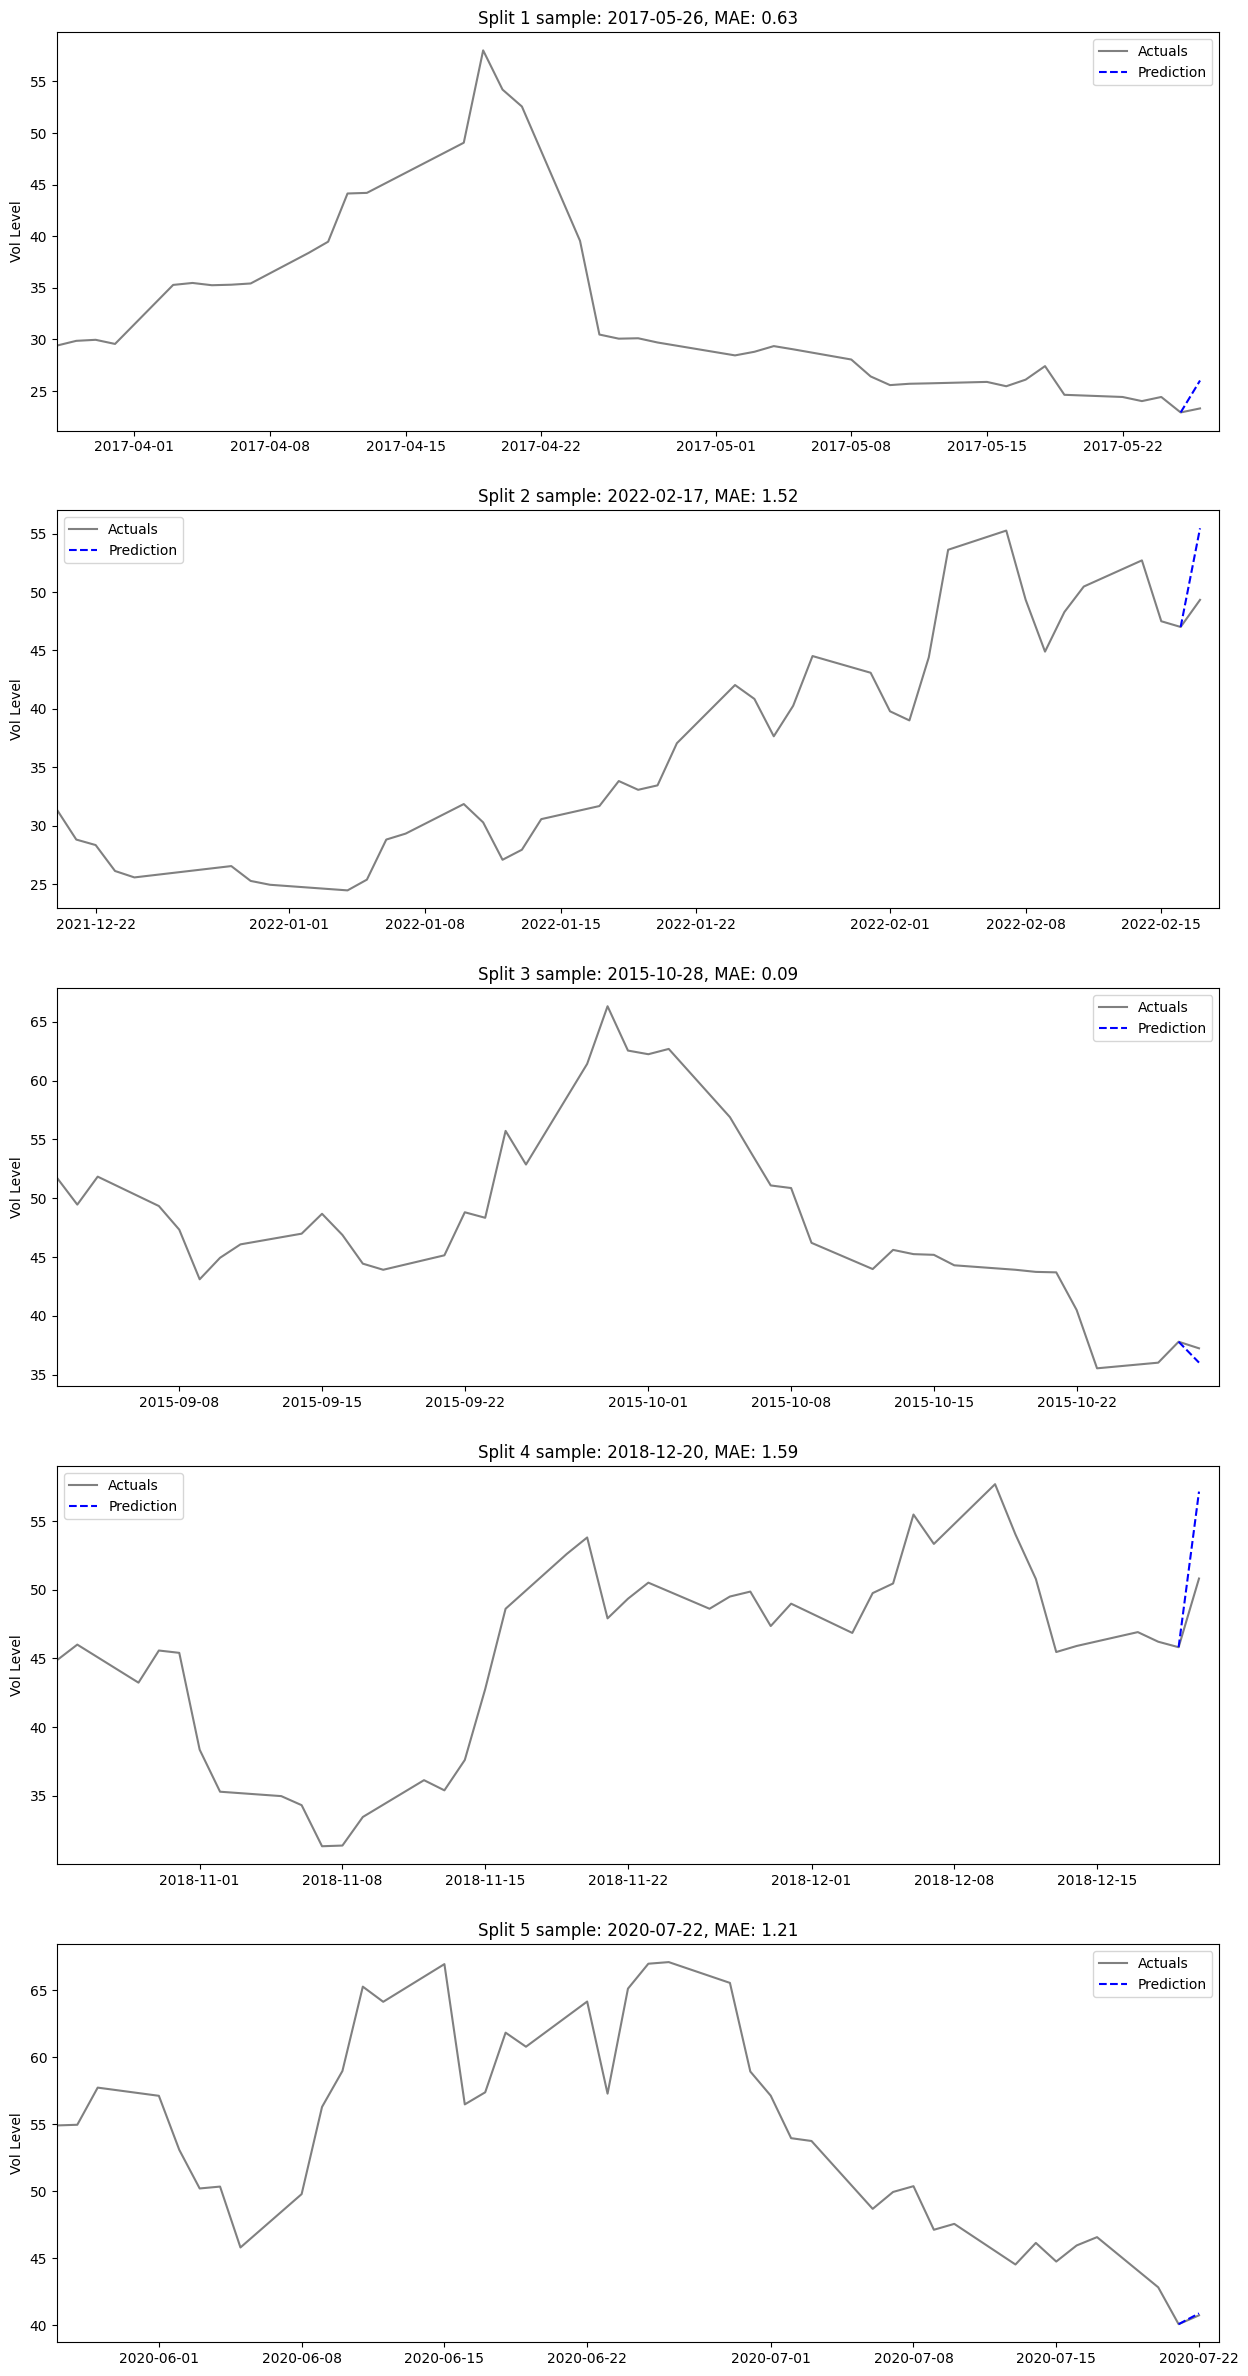

In [10]:
random_samples = np.random.choice(len(forecasts), size=5, replace=False)

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 30))

for i, idx in enumerate(random_samples):
    forecast_date = data.index[forecast_indices[idx]]
    forecast_value = forecasts[idx]
    preceding_data_idx = max(data.index.get_loc(forecast_date) - 40, 0)
    preceding_data = data.iloc[preceding_data_idx: data.index.get_loc(forecast_date) + 1]
    last_actual_date = preceding_data.index[-2]
    last_actual_value = preceding_data.values[-2]

    axes[i].plot(preceding_data.index, preceding_data.values, label='Actuals', linestyle='-', color='gray')
    axes[i].plot([last_actual_date, forecast_date], [last_actual_value, forecast_value], label='Prediction', linestyle='--', color='blue')
    
    axes[i].set_xlim([preceding_data.index.min(), forecast_date + pd.Timedelta(days=1)])
    
    axes[i].set_title(f'Split {i+1} sample: {forecast_date.strftime("%Y-%m-%d")}, MAE: {mae_scores[idx]:.2f}')
    axes[i].set_ylabel('Vol Level')
    axes[i].legend()

plt.show()